# Using the Bambi with HSSM

Bambi is a high-level Bayesian model-building interface written in Python. It's built on top of the PyMC probabilistic programming framework, and is designed to make it extremely easy to fit mixed-effects models common in social sciences settings using a Bayesian approach.

Bambi gives a lot of freedom to customze 

In [1]:
import arviz as az
import bambi as bmb
import jax
import multiprocessing as mp
import numpy as np
import numpyro
import pandas as pd
import pymc as pm
from pymc import sampling_jax
import pytensor
import pytensor.tensor as pt

# WFPT and LAN are two factory classes
from hssm import wfpt
from hssm.wfpt import lan
import ssms.basic_simulators

numpyro.set_host_device_count(jax.local_device_count())

/Users/yxu150/HSSM/.venv/lib/python3.9/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Using Base WFPT class 

In [2]:
WFPT_base = wfpt.WFPT

In [3]:
# Simulate some data
v_true, a_true, z_true, t_true, sv_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, sv_true], model="ddm", n_samples=1000
)
obs = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
obs

array([[ 2.42303371,  1.        ],
       [ 1.10999572,  1.        ],
       [ 1.38099217, -1.        ],
       ...,
       [ 5.03885365,  1.        ],
       [ 1.66399837,  1.        ],
       [ 1.55199313,  1.        ]])

### Bambi requires data to be in pandas format 

In [4]:
df_wfpt = pd.DataFrame(obs, columns=["rts", "choices"])

### Use Bambi to create an analytical solution of the WFPT likelihood function follows Navarro & Fuss (2009).

In [5]:
WFPTLikelihood = bmb.Likelihood(
    "WFPT", params=["v", "sv", "a", "z", "t"], parent="v", dist=WFPT_base
)
# You don't need to pass the link function for all the parameters when it's a non-distributional model.
# But if you want to use predictor for that parameter, you do need a link function
WFPTFamily = bmb.Family(
    "WFPT",
    likelihood=WFPTLikelihood,
    link={
        "v": "identity",
        "sv": "identity",
        "a": "identity",
        "z": "identity",
        "t": "identity",
    },
)
priors = {
    "Intercept": bmb.Prior("Uniform", lower=-3, upper=3),
    "sv": bmb.Prior("Uniform", lower=0.0, upper=1.2),
    "a": bmb.Prior("Uniform", lower=0.5, upper=2.0),
    "z": bmb.Prior("Uniform", lower=0.1, upper=0.9),
    "t": bmb.Prior("Uniform", lower=0.0, upper=2.0),
}

bmb_ddm = bmb.Model("c(rts,choices)  ~ 1", df_wfpt, family=WFPTFamily, priors=priors)
bmb_ddm

       Formula: c(rts,choices)  ~ 1
        Family: WFPT
          Link: v = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Uniform(lower: -3.0, upper: 3.0)
        
        Auxiliary parameters
            c(rts, choices)_z ~ Uniform(lower: 0.1, upper: 0.9)
            c(rts, choices)_a ~ Uniform(lower: 0.5, upper: 2.0)
            c(rts, choices)_sv ~ Uniform(lower: 0.0, upper: 1.2)
            c(rts, choices)_t ~ Uniform(lower: 0.0, upper: 2.0)

In [8]:
pytensor.config.floatX = "float32"

idata_bmb_ddm = bmb_ddm.fit(
    chains=2,
    draws=500,
    tune=500,
)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [c(rts, choices)_z, c(rts, choices)_a, c(rts, choices)_sv, c(rts, choices)_t, Intercept]
INFO:pymc:NUTS: [c(rts, choices)_z, c(rts, choices)_a, c(rts, choices)_sv, c(rts, choices)_t, Intercept]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 7 seconds.
INFO:pymc:Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 7 seconds.


In [9]:
az.summary(idata_bmb_ddm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"c(rts, choices)_z",0.504,0.013,0.481,0.529,0.001,0.000,401.0,565.0,1.00
"c(rts, choices)_a",1.545,0.032,1.491,1.605,0.001,0.001,482.0,438.0,1.00
"c(rts, choices)_sv",0.104,0.077,0.001,0.246,0.004,0.003,277.0,330.0,1.00
"c(rts, choices)_t",0.489,0.022,0.447,0.530,0.001,0.001,515.0,567.0,1.00
Intercept,0.496,0.038,0.421,0.563,0.002,0.001,413.0,450.0,1.01


array([[<AxesSubplot: title={'center': 'c(rts, choices)_z'}>,
        <AxesSubplot: title={'center': 'c(rts, choices)_z'}>],
       [<AxesSubplot: title={'center': 'c(rts, choices)_a'}>,
        <AxesSubplot: title={'center': 'c(rts, choices)_a'}>],
       [<AxesSubplot: title={'center': 'c(rts, choices)_sv'}>,
        <AxesSubplot: title={'center': 'c(rts, choices)_sv'}>],
       [<AxesSubplot: title={'center': 'c(rts, choices)_t'}>,
        <AxesSubplot: title={'center': 'c(rts, choices)_t'}>],
       [<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>]], dtype=object)

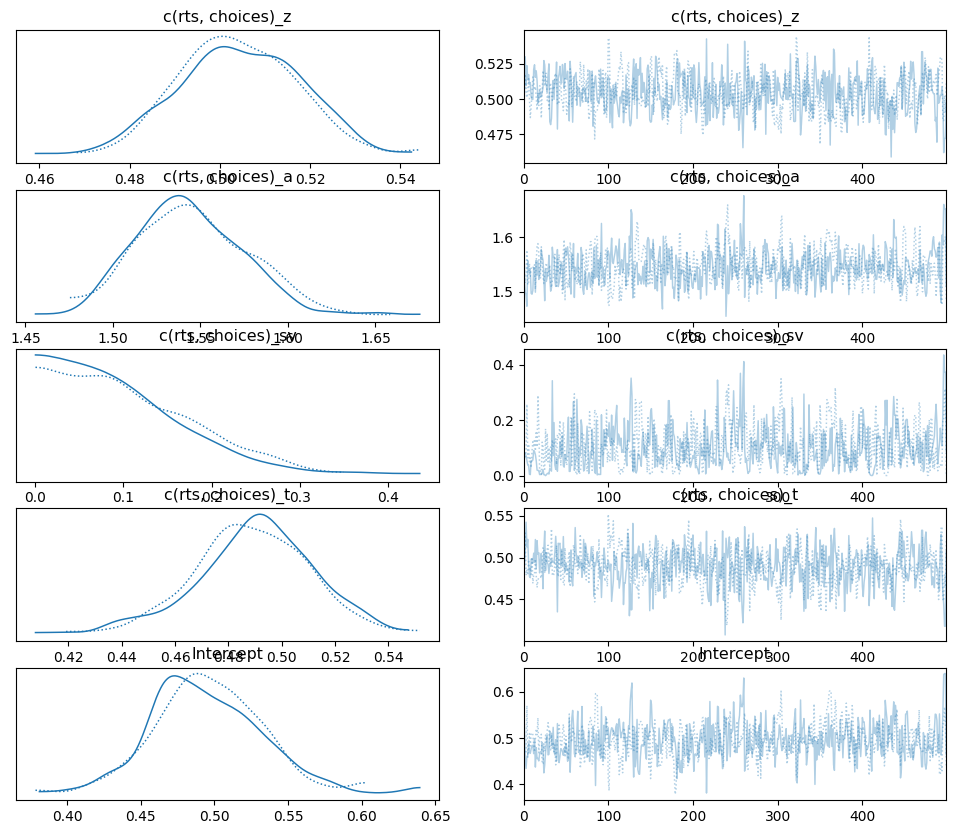

In [10]:
az.plot_trace(idata_bmb_ddm)

## Using the `LAN` factory class for LAN related functionalities

The LAN class has factory methods that produces LAN related log-likelihoods using either `aesara` or `jax` backend.


#### Create a LAN distribution directly from `WFPT.make_lan_distribution`

`WFPT.make_lan_distribution` conveniently wraps all steps above and create a `pymc.Distribution`.

In [11]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle_lan = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs_lan = np.column_stack([obs_angle_lan["rts"][:, 0], obs_angle_lan["choices"][:, 0]])
obs_lan

array([[ 2.78001714, -1.        ],
       [ 0.94799781,  1.        ],
       [ 2.30902863,  1.        ],
       ...,
       [ 2.47603631,  1.        ],
       [ 2.84901214,  1.        ],
       [ 3.02899909,  1.        ]])

In [12]:
df_lan = pd.DataFrame(obs_lan, columns=["rts", "choices"])

In [13]:
LAN_jax = wfpt.make_ssm_distribution(
    model="test.onnx",
    backend="jax",
    list_params=["v", "a", "z", "t", "theta"],
)

In [14]:
LAN_jax.logp(np.ones((1000, 2)), *([1.0] * 5)).eval()

array(3887.7363, dtype=float32)

### LAN using the aesara backend

As an alternative, the onnx model can also be translated directly into aesara:

#### Create a LAN distribution directly from `WFPT.make_lan_distribution`

When `backend` is not set or to `"aesara"`, `WFPT.make_lan_distribution` will make a log-likelihood function with aesara and make a `pymc.Distribution` with aesara backend.

In [15]:
LAN_pytensor = wfpt.make_ssm_distribution(
    model="test.onnx",
    backend="pytensor",
    list_params=["v", "a", "z", "t", "theta"],
)

### Create arbitrary WFPT distributions

The `WFPT` factory class provides a general `make_distribution` class method to generate an arbitrary `pymc.Distribution` from user-supplied log-likelihood functions and `RandomVariable` `Op`s.

```python
arbitrary_distribution = WFPT.make_distribution(
    loglike=some_likelihood_func,
    rv=some_RandomVariable_Op,
    list_params=["v", "a", "z", "t", "theta"] # A list of str specifying the names and order of the parameters
)
```

## Sampling from arbitrary LAN distributions

The class produced by the factory classes can then be used for sampling with `PyMC`

#### Sampling with PyMC from LAN distribution with JAX backend

In [ ]:
LAN_Likelihood_jax = bmb.Likelihood(
    "LAN", params=["v", "a", "z", "t", "theta"], parent="v", dist=LAN_jax
)
# You don't need to pass the link function for all the parameters when it's a non-distributional model.
# But if you want to use predictor for that parameter, you do need a link function
LAN_Family_jax = bmb.Family(
    "LAN",
    likelihood=LAN_Likelihood_jax,
    link={
        "v": "identity",
        "a": "identity",
        "z": "identity",
        "t": "identity",
        "theta": "identity",
    },
)
priors = {
    "Intercept": bmb.Prior("Uniform", lower=-3, upper=3, initval=0),
    "a": bmb.Prior("Uniform", lower=0.5, upper=5, initval=2),
    "z": bmb.Prior("Uniform", lower=0.1, upper=0.9, initval=0.5),
    "t": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
    "theta": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
}
bmb_lan_jax = bmb.Model(
    "c(rts,choices) ~ 1", df_lan, family=LAN_Family_jax, priors=priors
)
bmb_lan_jax

In [ ]:
pytensor.config.floatX = "float32"

jax_bmb_lan = bmb_lan_jax.fit(chains=2, draws=500, tune=500, mp_ctx="fork")

In [ ]:
az.summary(jax_bmb_lan)

In [ ]:
az.plot_trace(jax_bmb_lan)

#### Sampling with Pytensor from LAN distribution with pytensor backend

In [ ]:
LAN_Likelihood_pytensor = bmb.Likelihood(
    "LAN_pytensor", params=["v", "a", "z", "t", "theta"], parent="v", dist=LAN_pytensor
)
# You don't need to pass the link function for all the parameters when it's a non-distributional model.
# But if you want to use predictor for that parameter, you do need a link function
LAN_Family_pytensor = bmb.Family(
    "LAN_pytensor",
    likelihood=LAN_Likelihood_pytensor,
    link={
        "v": "identity",
        "a": "identity",
        "z": "identity",
        "t": "identity",
        "theta": "identity",
    },
)
priors = {
    "Intercept": bmb.Prior("Uniform", lower=-3, upper=3, initval=0),
    "a": bmb.Prior("Uniform", lower=0.5, upper=5, initval=2),
    "z": bmb.Prior("Uniform", lower=0.1, upper=0.9, initval=0.5),
    "t": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
    "theta": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
}
bmb_lan_pytensor = bmb.Model(
    "c(rts,choices)  ~ 1", df_lan, family=LAN_Family_pytensor, priors=priors
)
bmb_lan_pytensor

In [ ]:
pytensor_bmb_lan = bmb_lan_pytensor.fit(
    chains=2,
    draws=500,
    tune=500,
)

In [ ]:
az.summary(pytensor_bmb_lan)

In [ ]:
az.plot_trace(pytensor_bmb_lan)